<a href="https://colab.research.google.com/github/neel26desai/cmpe258_transfer_learning_cv/blob/main/Transfer_Learning_Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

Downloading the data and making a train, validate and test tensorflow datasets

In [ ]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

68606236/68606236 [==============================] - 0s 0us/step
Found 2000 files belonging to 2 classes.


In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


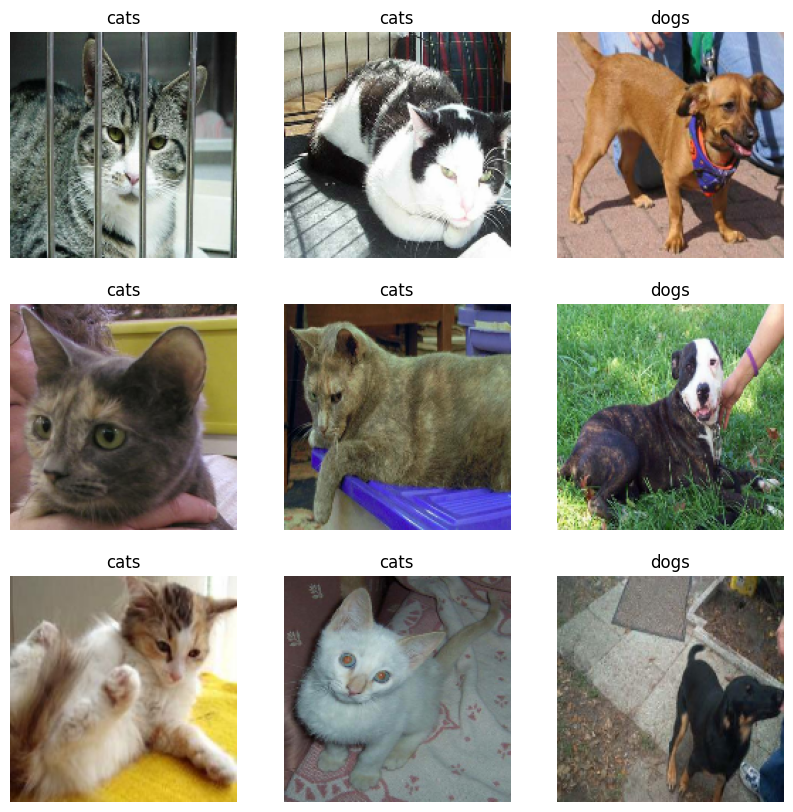

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
#the orignal dataset has train and validation set, it doesn't have a test set
#we figure our how many batces are there in the validation dataset
val_batches = tf.data.experimental.cardinality(validation_dataset)
#out of them we assign the 20% of them to test set and rest wil remain in the validation
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
#prefetching overlaps preprocessing and model execution of a training step, whe the model executing training step s, the input pipeline is reading the data for step s+1
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
#creating a sequential data augmentation pipelinr , where the data is first flipped horizontally and then some rotation is applied to it
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

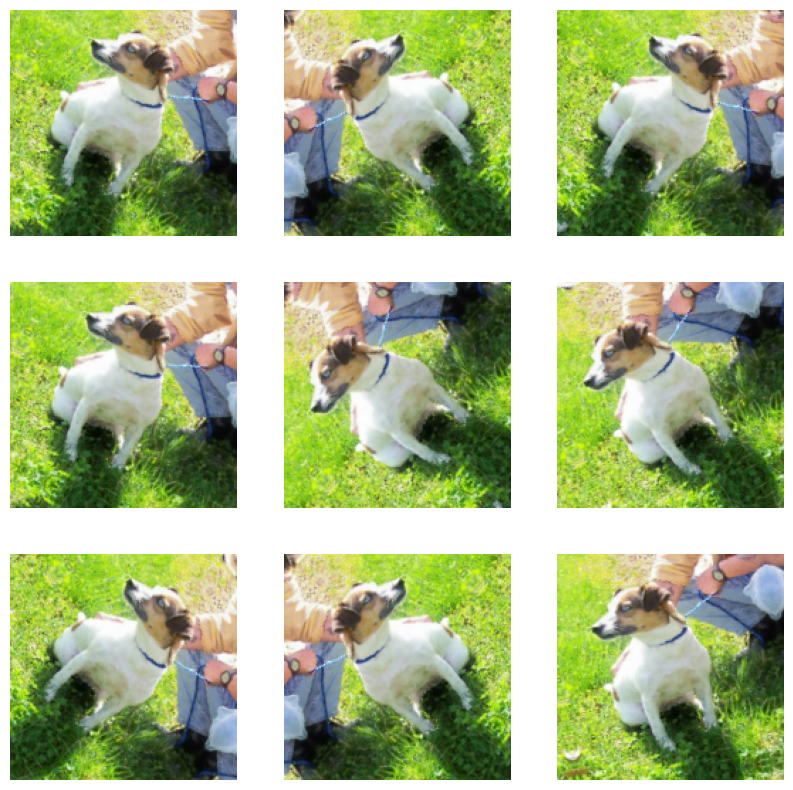

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  # we have one image which we will pass throughour data augmentation pipelines 9 to see how different the outputs are eac time
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

Rescaling pixel values, we plan on using the MobileNetV2 as the base model for our transfer learning, now this model requires us to have the pixel values between -1 and 1.

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
preprocess_input # this is basically a function which will conver the image in the required mode

<function keras.src.applications.mobilenet_v2.preprocess_input(x, data_format=None)>

In [ ]:
#getting the base model
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False, # does not include the final output, layer of the model, instead we'll add our own output layer
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


##Feature Extraction

In [ ]:
base_model.trainable = False

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

In [ ]:
#the model will return 5,5 spatail location for 1280 feature
# we use a global pooling layer to generate the features to a single 1280 element 1,1280, whicj we
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


So far we applied the normalization, feature extraction and gloval pooling to just a single layer. We can now use the keras functional API to chain everything together

In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3)) #eachimage is 160 by 160 and has 3 channels
x = data_augmentation(inputs)
x = preprocess_input(x) #Normalizing the inptut for mobilenet_v2
x = base_model(x, training=False)# gettting the  feature 5,5,1280 for each image
x = global_average_layer(x) #applying the global pooling layer to get a vector of 1280 for each image
x = tf.keras.layers.Dropout(0.2)(x) # a dropout layer
outputs = prediction_layer(x)#maki
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                             

In [ ]:
len(model.trainable_variables)

2

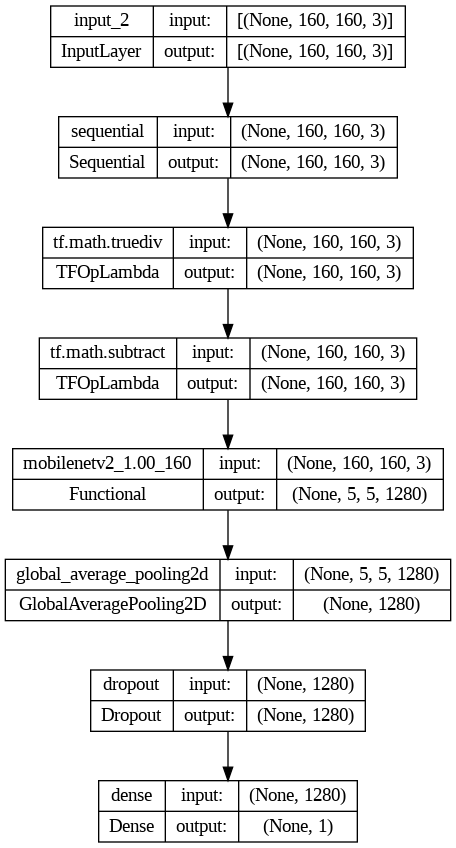

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 4s 52ms/step - loss: 0.9578 - accuracy: 0.4901


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.96
initial accuracy: 0.49


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 9s 61ms/step - loss: 0.7354 - accuracy: 0.5735 - val_loss: 0.5655 - val_accuracy: 0.7178
Epoch 2/10
63/63 [==============================] - 4s 51ms/step - loss: 0.5368 - accuracy: 0.7280 - val_loss: 0.4114 - val_accuracy: 0.8639
Epoch 3/10
63/63 [==============================] - 3s 50ms/step - loss: 0.4291 - accuracy: 0.8105 - val_loss: 0.3145 - val_accuracy: 0.9183
Epoch 4/10
63/63 [==============================] - 4s 66ms/step - loss: 0.3607 - accuracy: 0.8645 - val_loss: 0.2535 - val_accuracy: 0.9480
Epoch 5/10
63/63 [==============================] - 3s 51ms/step - loss: 0.3143 - accuracy: 0.8835 - val_loss: 0.2092 - val_accuracy: 0.9567
Epoch 6/10
63/63 [==============================] - 3s 51ms/step - loss: 0.2845 - accuracy: 0.8955 - val_loss: 0.1870 - val_accuracy: 0.9629
Epoch 7/10
63/63 [==============================] - 4s 67ms/step - loss: 0.2693 - accuracy: 0.9010 - val_loss: 0.1651 - val_accuracy: 0.9691
Epoch 8/10
63

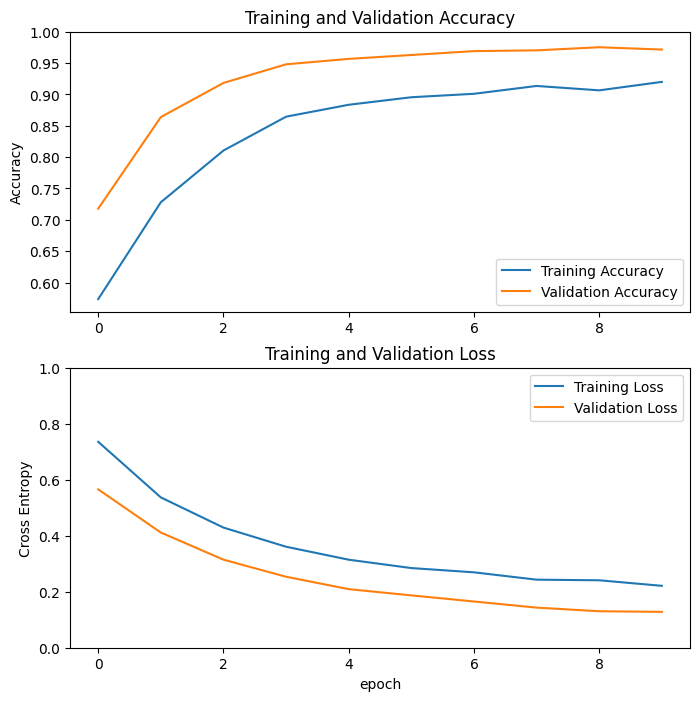

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#Fine Tuning

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                             

In [ ]:
len(model.trainable_variables)

56

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=validation_dataset)

Epoch 11/20
63/63 [==============================] - 15s 82ms/step - loss: 0.1594 - accuracy: 0.9385 - val_loss: 0.0640 - val_accuracy: 0.9777
Epoch 12/20
63/63 [==============================] - 4s 62ms/step - loss: 0.1210 - accuracy: 0.9555 - val_loss: 0.0506 - val_accuracy: 0.9814
Epoch 13/20
63/63 [==============================] - 4s 57ms/step - loss: 0.0995 - accuracy: 0.9635 - val_loss: 0.0467 - val_accuracy: 0.9814
Epoch 14/20
63/63 [==============================] - 5s 73ms/step - loss: 0.0939 - accuracy: 0.9660 - val_loss: 0.0442 - val_accuracy: 0.9851
Epoch 15/20
63/63 [==============================] - 4s 57ms/step - loss: 0.0920 - accuracy: 0.9590 - val_loss: 0.0433 - val_accuracy: 0.9839
Epoch 16/20
63/63 [==============================] - 4s 58ms/step - loss: 0.0779 - accuracy: 0.9685 - val_loss: 0.0409 - val_accuracy: 0.9851
Epoch 17/20
63/63 [==============================] - 5s 75ms/step - loss: 0.0858 - accuracy: 0.9645 - val_loss: 0.0396 - val_accuracy: 0.9889
Epoch

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

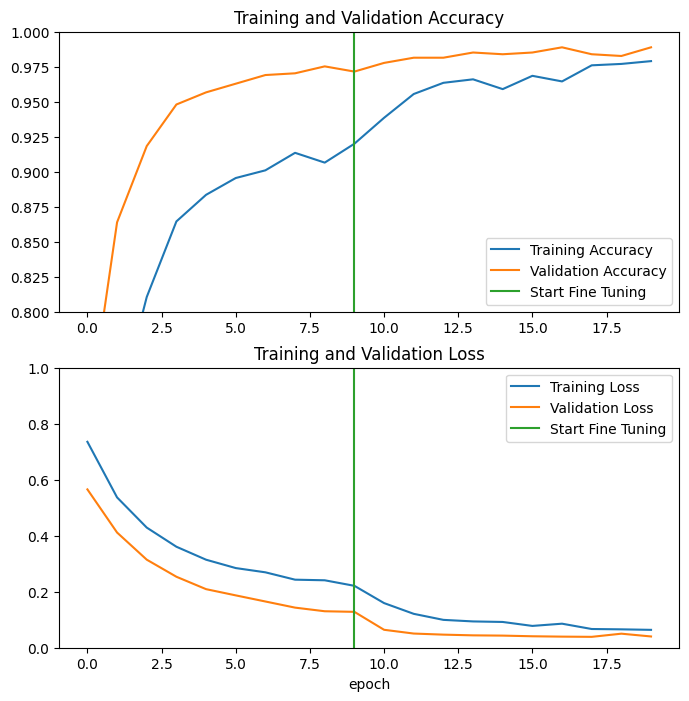

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 1s 47ms/step - loss: 0.0305 - accuracy: 0.9844
Test accuracy : 0.984375


Predictions:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Labels:
 [0 1 1 1 0 1 1 0 0 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1 0 1 0 0 0 1 1 0]


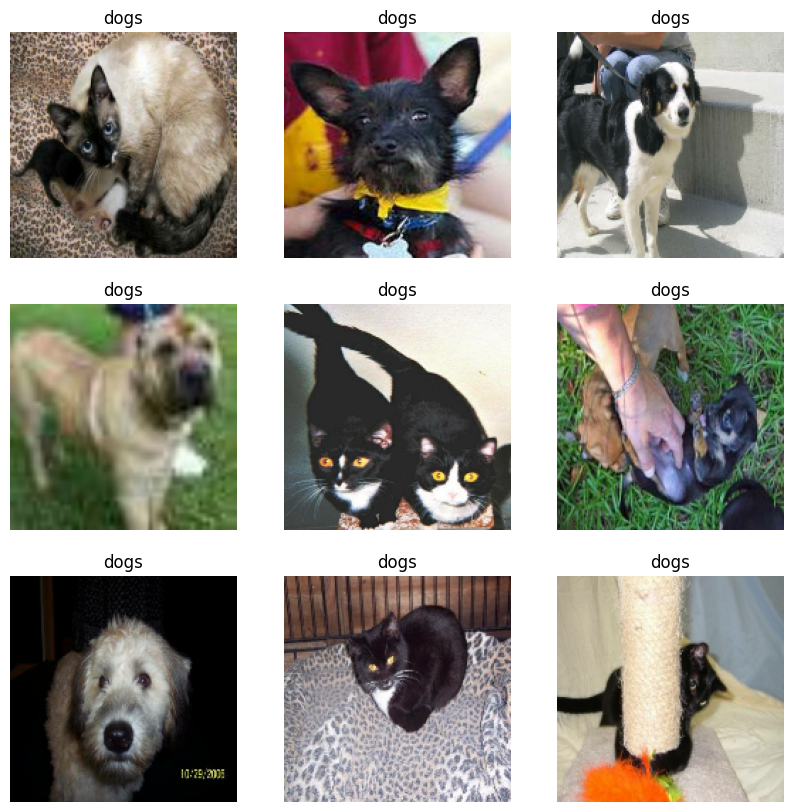

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

Reference::

https://www.tensorflow.org/tutorials/images/transfer_learning